In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Bird baths in Australia

In [2]:
# load the data
path = '/Users/liamhettinger/Documents/Portfolio_work/Data/bird_baths.csv'
birds = pd.read_csv(path)
birds.head()

,survey_year,urban_rural,bioregions,bird_type,bird_count
0,2014.0,Urban,South Eastern Queensland,Bassian Thrush,0
1,2014.0,Urban,South Eastern Queensland,Chestnut-breasted Mannikin,0
2,2014.0,Urban,South Eastern Queensland,Wild Duck,0
3,2014.0,Urban,South Eastern Queensland,Willie Wagtail,0
4,2014.0,Urban,South Eastern Queensland,Regent Bowerbird,0


The **goal** is to predict which birds are more likely to be seen in an urban enviroment or a rural enviroment

In [3]:
#potential birds to be seen
birds_list = [
    'Noisy Miner',
    'Australian Magpie',
    'Rainbow Lorikeet',
    'Red Wattlebird',
    'Superb Fairy-wren',
    'Magpie-lark',
    'Pied Currawong',
    'Crimson Rosella',
    'Eastern Spinebill',
    'Spotted Dove',
    "Lewin's Honeyeater",
    'Satin Bowerbird',
    'Crested Pigeon',
    'Grey Fantail',
    'Red-browed Finch',
]

In [4]:
#filtering out birds not on above list
birds = birds[birds['bird_type'].isin(birds_list)]
birds['bird_type'].unique()

array(['Satin Bowerbird', 'Eastern Spinebill', 'Red Wattlebird',
       'Crimson Rosella', 'Australian Magpie', 'Pied Currawong',
       'Magpie-lark', 'Crested Pigeon', "Lewin's Honeyeater",
       'Superb Fairy-wren', 'Rainbow Lorikeet', 'Red-browed Finch',
       'Noisy Miner', 'Spotted Dove', 'Grey Fantail'], dtype=object)

### Data Exploration

In [5]:
#creating target variable
birds['bird'] = np.where(birds['bird_count'] > 0, 1, 0)
birds.head()

,survey_year,urban_rural,bioregions,bird_type,bird_count,bird
22,2014.0,Urban,South Eastern Queensland,Satin Bowerbird,0,0
24,2014.0,Urban,South Eastern Queensland,Eastern Spinebill,0,0
35,2014.0,Urban,South Eastern Queensland,Red Wattlebird,0,0
44,2014.0,Urban,South Eastern Queensland,Crimson Rosella,0,0
84,2014.0,Urban,South Eastern Queensland,Australian Magpie,0,0


In [6]:
birds.isnull().sum()

survey_year    15
urban_rural    15
bioregions     15
bird_type       0
bird_count      0
bird            0
dtype: int64

In [7]:
birds.dtypes

survey_year    float64
urban_rural     object
bioregions      object
bird_type       object
bird_count       int64
bird             int64
dtype: object

In [8]:
#probability a bird will be seen in either an urban or rural setting
probability = pd.pivot_table(data = birds, index=['bird_type'], columns=['urban_rural'], values = ['bird'])
probability

bird          
urban_rural            Rural     Urban
bird_type                             
Australian Magpie   0.258503  0.282675
Crested Pigeon      0.095238  0.147416
Crimson Rosella     0.224490  0.135258
Eastern Spinebill   0.295918  0.100304
Grey Fantail        0.282313  0.060790
Lewin's Honeyeater  0.282313  0.075988
Magpie-lark         0.112245  0.193009
Noisy Miner         0.200680  0.354103
Pied Currawong      0.108844  0.189970
Rainbow Lorikeet    0.136054  0.296353
Red Wattlebird      0.119048  0.206687
Red-browed Finch    0.261905  0.060790
Satin Bowerbird     0.142857  0.135258
Spotted Dove        0.037415  0.212766
Superb Fairy-wren   0.363946  0.095745

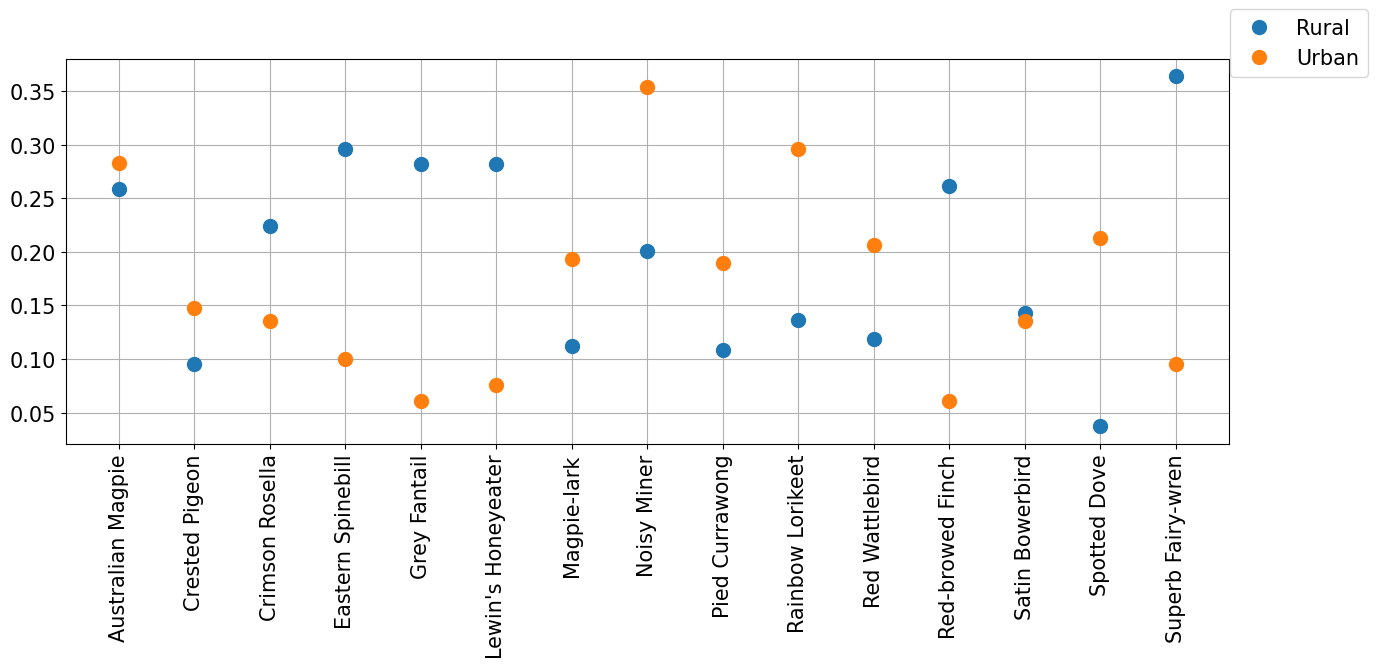

In [9]:
#The probability a given bird will be seen in an urban or rural setting
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(probability[('bird', 'Rural')],'o',markersize='10', label='Rural')
ax.plot(probability[('bird', 'Urban')],'o',markersize='10', label='Urban')
ax.grid(True)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
fig.legend(fontsize=15)
plt.show()

### Model

In [10]:
#defining variables 
y = birds['bird']
X = birds.drop(['survey_year','bird','bird_count'], axis = 1) 
#X variables are urban_rural, bird_type and bioregions

In [11]:
#splitting variables into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [12]:
#creating pipeline
pipe = Pipeline(steps=[
    ('encoder',OneHotEncoder()), #encodes categorical features. 1 of n conversion
    ('imputer', SimpleImputer()), # imputing na rows
    ('reg', LogisticRegression()) #model
])

In [13]:
#fitting pipeline
pipe.fit(X_train,y_train)

Pipeline(steps=[('encoder', OneHotEncoder()), ('imputer', SimpleImputer()),
                ('reg', LogisticRegression())])

In [14]:
#predicting the y_test probabilities
y_test_proba_reg = pipe.predict_proba(X_test)[:,1]

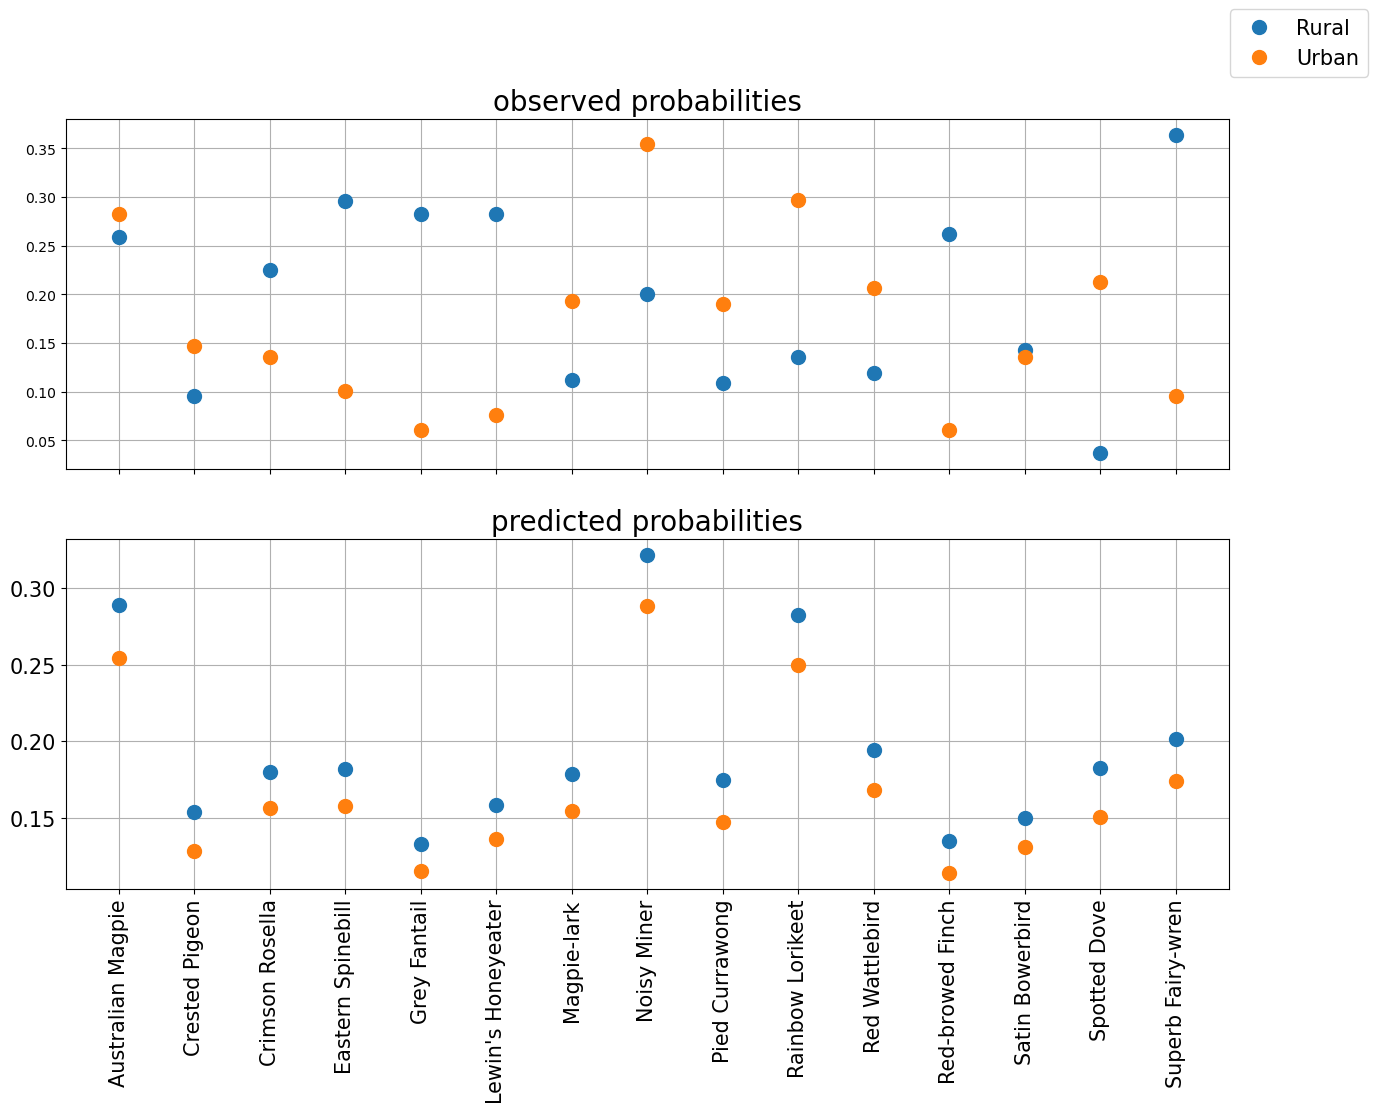

In [15]:
#Comparing actual probability and predicted probability

results_log = X_test.copy()
results_log['proba_logistic'] = y_test_proba_reg

probability_test_log = pd.pivot_table(data=results_log, values='proba_logistic', index='bird_type', columns='urban_rural', aggfunc = 'mean')

fig, ax = plt.subplots(2,1,figsize=(15,10),sharex=True)

ax[0].plot(probability[('bird', 'Rural')],'o',markersize='10', label='Rural')
ax[0].plot(probability[('bird', 'Urban')],'o',markersize='10', label='Urban')
ax[0].grid(True)
ax[0].set_title('observed probabilities', fontsize=20)

ax[1].plot(probability_test_log.Rural,'o',markersize='10')
ax[1].plot(probability_test_log.Urban,'o',markersize='10')
ax[1].grid(True)
ax[1].set_title('predicted probabilities', fontsize=20)
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15)
fig.legend(fontsize=15)
plt.show()

## XGBoost

In [16]:
#creating pipeline
pipe = Pipeline(steps=[
    ('hotencoder',OneHotEncoder()),
    ('Simple_Input', SimpleImputer()),
    ('xgb', xgb.XGBClassifier(objective="binary:logistic", random_state=42))
])

In [17]:
#fitting pipeline
pipe.fit(X, y)

Pipeline(steps=[('hotencoder', OneHotEncoder()),
                ('Simple_Input', SimpleImputer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [18]:
#predicting the y_test probabilities
y_test_proba_XGB = pipe.predict_proba(X_test)[:,1]

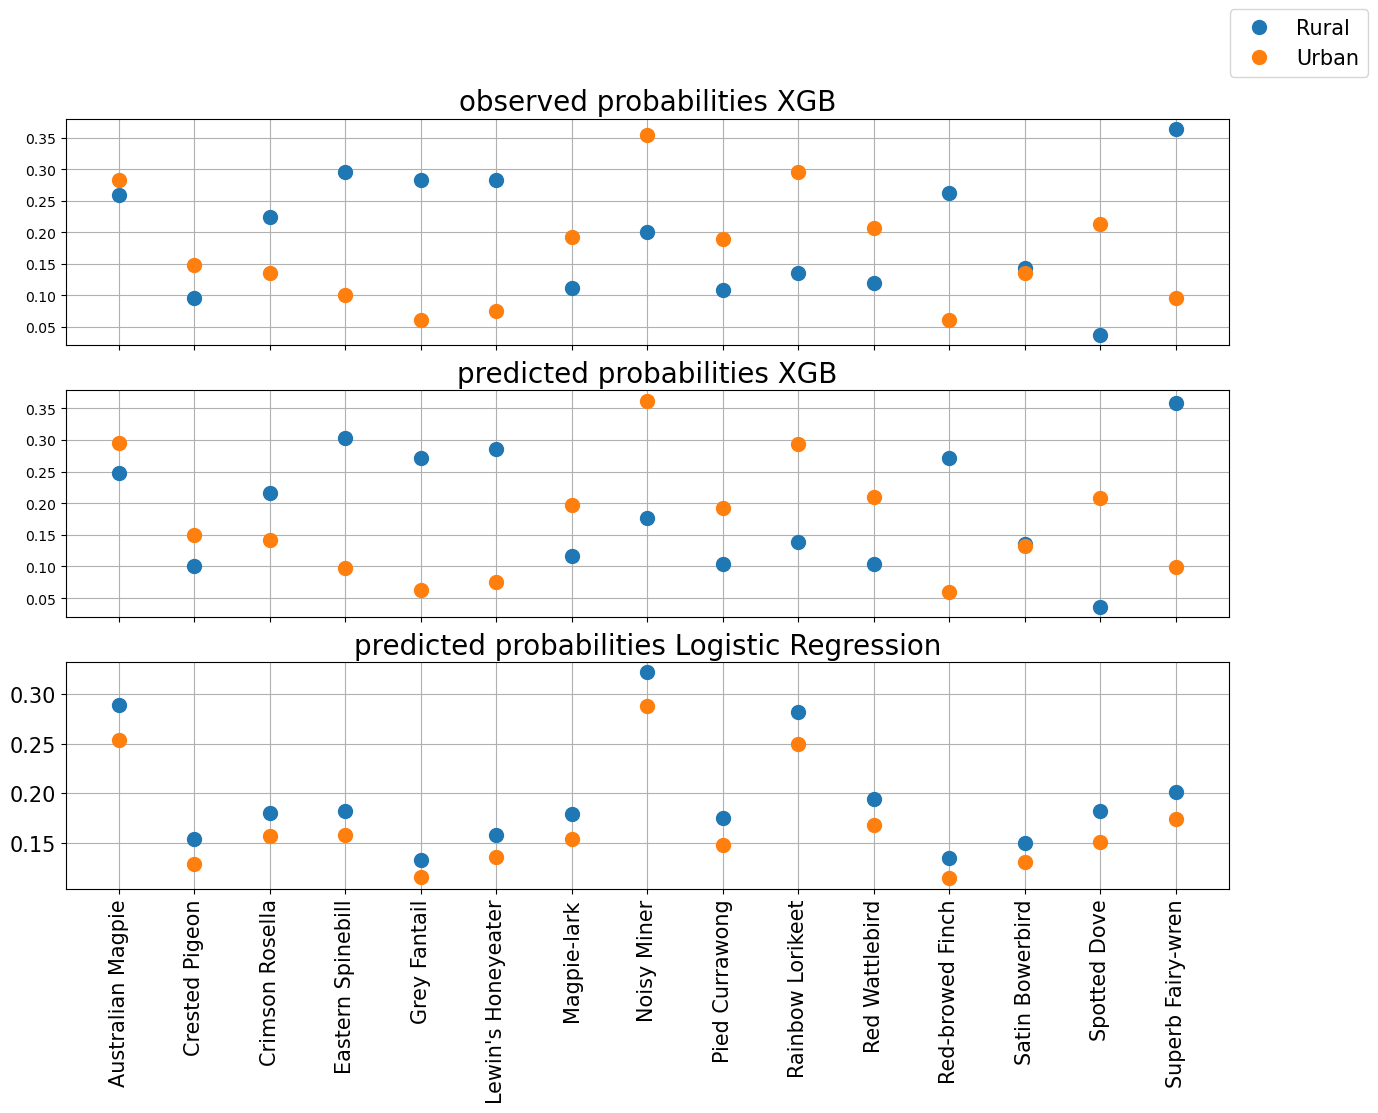

In [19]:
#Comparing actual probability and predicted probability
results_XGB = X_test.copy()
results_XGB['proba_XGB'] = y_test_proba_XGB
probability_test_XGB = pd.pivot_table(data=results_XGB, values='proba_XGB', index='bird_type', columns='urban_rural', aggfunc = 'mean')

fig, ax = plt.subplots(3,1,figsize=(15,10),sharex=True)

ax[0].plot(probability[('bird', 'Rural')],'o',markersize='10', label='Rural')
ax[0].plot(probability[('bird', 'Urban')],'o',markersize='10', label='Urban')
ax[0].grid(True)
ax[0].set_title('observed probabilities XGB', fontsize=20)

ax[1].plot(probability_test_XGB.Rural,'o',markersize='10')
ax[1].plot(probability_test_XGB.Urban,'o',markersize='10')
ax[1].grid(True)
ax[1].set_title('predicted probabilities XGB', fontsize=20)

ax[2].plot(probability_test_log.Rural,'o',markersize='10')
ax[2].plot(probability_test_log.Urban,'o',markersize='10')
ax[2].grid(True)
ax[2].set_title('predicted probabilities Logistic Regression', fontsize=20)

plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15)
fig.legend(fontsize=15)
plt.show()